# Evaluation / results

In [43]:
import pandas as pd
import numpy as np

### Performace: nDCG, Recall and Precision

In [44]:
import math
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) #topK
    idealOrder = ground_truth
    idealDCG = 0.0
    
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))
    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


### Diversity: ILD, and Entropy

In [45]:
# intra list distance
def ILD(_recList):
    
    
    _recList_if_ids = [InnerID_to_iiMatrixID[Inner_ID] for Inner_ID in _recList]
#     _recList_if_ids = list(map(int(InnerID_to_iiMatrixID), _recList))   
    
    
    totalDisSimilarityPerUser = 0
    topK =  len(_recList)
    
    c = []
    for item_i in _recList_if_ids:            
        for item_j in _recList_if_ids:
            if (item_i != item_j):
                # this vector (i) and that vector (j)
                totalDisSimilarityPerUser += (1.0 - itemItemSimilarityByFeature[item_i, item_j])
    
    diversityPerUser = (totalDisSimilarityPerUser * 2.0) / (topK * (topK - 1.0))
    return (diversityPerUser)


def ENTROPY_(_recList):
    _recList_ids = list(map(int, _recList))
    feature_count_vector = item_features_df[item_features_df.index.isin(_recList_ids)].sum(axis=0)
    
    # turn it back to a list of labels so we can pass it to entropy_()
    _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index for j in range(feature_count_vector[i])]
#     print(_recList_item_features)
    # send the labels to the entropy_() to calculate the netropy over all the labels combined.
    return entropy_(_recList_item_features)

    
def entropy_(labels, base=None):
    from math import log, e
    """ Computes entropy of label distribution. """

    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)
    return ent

### Fairness: Calibration

In [46]:
def KullbackLeiblerDivergence(interactDist, recommendedDist):
    import numpy as np
    alpha = 0.01 # not really a tuning parameter, it's there to make the computation more numerically stable.
    klDive = 0.0
    for i in range(len(interactDist)):
        # By convention, 0 * ln(0/a) = 0, so we can ignore keys in q that aren't in p
        if interactDist[i] == 0.0:
            continue
        # if q = recommendationDist and p = interactedDist, q-hat is the adjusted q.
        # given that KL divergence diverges if recommendationDist or q is zero, we instead use q-hat = (1-alpha).q + alpha . p
        recommendedDist[i] = (1 - alpha) * recommendedDist[i] + alpha * interactDist[i]
        klDive += interactDist[i] * np.log2(interactDist[i] / recommendedDist[i])

    return klDive

def ComputeGenreDistribution(itemList):
    return item_features_df[item_features_df.index.isin(itemList)].sum(axis=0) / len(itemList)


# it's calculated for each user
def Calibration(groundTruth, _recList):
    
    recommendedDist = ComputeGenreDistribution(_recList)
    interactDist = ComputeGenreDistribution(groundTruth)
    
    klDive = KullbackLeiblerDivergence(interactDist, recommendedDist)
    return klDive

# Fairness: Statistical parity

In [363]:
def SP_recall(_test_set, _recList):
    
    _test_set_pro = []
    _test_set_unpro = []
    notFoundItems = []
    
    for i in np.unique(_test_set):
        try:
            if isProtected(i):
                _test_set_pro.append(i)
            else:
                _test_set_unpro.append(i)
        except IndexError:
            notFoundItems.append(i)
            
#     print('error count in test: ', len(set(notFoundItems)))
    notFoundItems = []
            
    _recList_pro = []
    _recList_unpro = []
    
    for j in np.unique(_recList):
        try:
            if isProtected(j):
                _recList_pro.append(j)
            else:
                _recList_unpro.append(j)
        except:
            notFoundItems.append(j)
            
#     print('error count in reclist: ', len(set(notFoundItems)))
    
#     hit = len(set(_recList).intersection(set(_test_set)))
#     return hit / float(len(_test_set))

#     print (len(set(_test_set_pro)),len(set(_test_set_unpro)))
    hit_pro = len(set(_recList_pro).intersection(set(_test_set_pro)))
    hit_unpro = len(set(_recList_unpro).intersection(set(_test_set_unpro)))

#     if (hit_pro != 0.0) & (hit_unpro != 0.0):
#         return (hit_pro * 100.0 / hit_unpro)
#     elif (hit_pro != 0.0) & (hit_unpro == 0.0):
#         return 100.0
#     elif (hit_pro == 0.0) & (hit_unpro != 0.0):
#         return 0.0
#     elif (hit_pro == 0.0) & (hit_unpro == 0.0):
#         return (0.0)
    
    return (hit_pro, hit_unpro)

### issue: why don't we have items in the unprotected group pas? eh?

In [362]:
# for uid in range(10):
#     test_items = groundTruth.loc[(groundTruth['userid'] == uid) & (groundTruth['rating'] >= 4), 'itemid'].tolist()
# #     print(test_items)
#     top_items = nmf_recs.loc[nmf_recs['userid'] == uid, 'itemid'].tolist()[:10]
# #     print(top_items)
                                  
#     print(SP_recall(test_items, top_items))

In [277]:
def REP_SP(_recList):
    # statistical parity per user list
#     _recList_ids = [InnerID_to_iiMatrixID[Inner_ID] for Inner_ID in _recList]
    
    pro_c = 0.0
    unpro_c = 0.0
    notFoundItems = []
#     for itemid in _recList_ids:
    for itemid in _recList:
        try:
            if isProtected(itemid):
                pro_c += 1
            else:
                unpro_c += 1
        except IndexError:
            notFoundItems.append(itemid)

#     print('error count rep_sp: ', len(set(notFoundItems)))

    # we can also divide it by 10, but we don't since we're taking the ratio
#     print(pro_c, unpro_c)
#     if unpro_c != 0:
#         statistical_parity = pro_c * 1.0 / unpro_c * 1.0
#         return (statistical_parity * 10.0)
    
#     return (100)
    return (pro_c, unpro_c)

In [361]:
# test_items = groundTruth.loc[(groundTruth['userid'] == 6) & (groundTruth['rating'] >= 4), 'itemid'].tolist()
# top_items = nmf_recs.loc[nmf_recs['userid'] == 1, 'itemid'].tolist()[:10]
# # print(list(top_items))

# REP_SP(top_items)

### ----------------------------------- data input ------------------------------------------

### This should be changed based on the dataset and what the system/we want.

In [410]:
# pro_dims_dict = {'popularity': ['notpop'], 'language': ['ab', 'as', 'ay', 'be', 'bi', 'br', 'dz', 'ff', 'fo', 'fy', 'ha', 'ht', 'ig', 'ki', 'kw', 'ky', 'lb', 'ln', 'lo', 'lv', 'mh', 'ml', 'mt', 'nb', 'ne', 'ny', 'rw', 'sc', 'se', 'sg', 'si', 'sl', 'sm', 'sn', 'st', 'tg', 'tk', 'tn', 'to', 'tt', 'ty', 'ug', 'uz'], 'runtime': ['short'], 'production_countries': ['AN', 'AQ', 'AZ', 'BB', 'BD', 'BM', 'BN', 'CG', 'DO', 'ET', 'GI', 'GN', 'HN', 'KE', 'KG', 'KP', 'KY', 'LA', 'LV', 'MD', 'ME', 'MG', 'MM', 'MO', 'MQ', 'NG', 'NI', 'PF', 'PG', 'SA', 'SO', 'SV', 'SY', 'TF', 'UG', 'WS', 'YU'], 'genres': ['Adult', 'Foreign', 'TV Movie', 'War', 'Western'], 'revenue': ['high'], 'year': ['old']}
pro_dims_dict = {'runtime': ['short'], 'production_countries': ['AF', 'AL', 'AM', 'AN', 'AO', 'AQ', 'AW', 'AZ', 'BB', 'BD', 'BF', 'BM', 'BN', 'BO', 'BT', 'BY', 'CD', 'CG', 'CI', 'CR', 'CS', 'DO', 'DZ', 'EE', 'EG', 'ET', 'GE', 'GH', 'GI', 'GN', 'HN', 'IQ', 'JO', 'KE', 'KG', 'KH', 'KP', 'KW', 'KY', 'LA', 'LB', 'LR', 'LV', 'MC', 'MD', 'ME', 'MG', 'ML', 'MM', 'MN', 'MO', 'MQ', 'MR', 'NA', 'NG', 'NI', 'NP', 'PA', 'PF', 'PG', 'PH', 'PR', 'PS', 'PY', 'QA', 'RW', 'SA', 'SK', 'SN', 'SO', 'SV', 'SY', 'TD', 'TF', 'TJ', 'TN', 'TZ', 'UG', 'UM', 'UY', 'UZ', 'VE', 'VN', 'WS', 'XG', 'YU', 'ZW'], 'language': ['ab', 'am', 'as', 'ay', 'be', 'bi', 'bm', 'ca', 'ce', 'cr', 'cy', 'dz', 'ff', 'fo', 'fy', 'gu', 'ha', 'ht', 'ig', 'ki', 'kn', 'ku', 'ky', 'lb', 'ln', 'lo', 'lt', 'mh', 'mr', 'nb', 'oc', 'rw', 'sc', 'se', 'sg', 'sl', 'sm', 'sn', 'te', 'tg', 'tk', 'tn', 'to', 'ug', 'uz', 'wo'], 'year': ['old'], 'revenue': ['low'], 'popularity': ['notpop'], 'genres': ['Adult', 'Documentary', 'Foreign', 'TV Movie', 'Western']}
print(pro_dims_dict)

{'runtime': ['short'], 'production_countries': ['AF', 'AL', 'AM', 'AN', 'AO', 'AQ', 'AW', 'AZ', 'BB', 'BD', 'BF', 'BM', 'BN', 'BO', 'BT', 'BY', 'CD', 'CG', 'CI', 'CR', 'CS', 'DO', 'DZ', 'EE', 'EG', 'ET', 'GE', 'GH', 'GI', 'GN', 'HN', 'IQ', 'JO', 'KE', 'KG', 'KH', 'KP', 'KW', 'KY', 'LA', 'LB', 'LR', 'LV', 'MC', 'MD', 'ME', 'MG', 'ML', 'MM', 'MN', 'MO', 'MQ', 'MR', 'NA', 'NG', 'NI', 'NP', 'PA', 'PF', 'PG', 'PH', 'PR', 'PS', 'PY', 'QA', 'RW', 'SA', 'SK', 'SN', 'SO', 'SV', 'SY', 'TD', 'TF', 'TJ', 'TN', 'TZ', 'UG', 'UM', 'UY', 'UZ', 'VE', 'VN', 'WS', 'XG', 'YU', 'ZW'], 'language': ['ab', 'am', 'as', 'ay', 'be', 'bi', 'bm', 'ca', 'ce', 'cr', 'cy', 'dz', 'ff', 'fo', 'fy', 'gu', 'ha', 'ht', 'ig', 'ki', 'kn', 'ku', 'ky', 'lb', 'ln', 'lo', 'lt', 'mh', 'mr', 'nb', 'oc', 'rw', 'sc', 'se', 'sg', 'sl', 'sm', 'sn', 'te', 'tg', 'tk', 'tn', 'to', 'ug', 'uz', 'wo'], 'year': ['old'], 'revenue': ['low'], 'popularity': ['notpop'], 'genres': ['Adult', 'Documentary', 'Foreign', 'TV Movie', 'Western']}


In [411]:
from functools import reduce
pro = reduce(lambda x,y: x+y, pro_dims_dict.values())
print(pro)
print(len(pro))

['short', 'AF', 'AL', 'AM', 'AN', 'AO', 'AQ', 'AW', 'AZ', 'BB', 'BD', 'BF', 'BM', 'BN', 'BO', 'BT', 'BY', 'CD', 'CG', 'CI', 'CR', 'CS', 'DO', 'DZ', 'EE', 'EG', 'ET', 'GE', 'GH', 'GI', 'GN', 'HN', 'IQ', 'JO', 'KE', 'KG', 'KH', 'KP', 'KW', 'KY', 'LA', 'LB', 'LR', 'LV', 'MC', 'MD', 'ME', 'MG', 'ML', 'MM', 'MN', 'MO', 'MQ', 'MR', 'NA', 'NG', 'NI', 'NP', 'PA', 'PF', 'PG', 'PH', 'PR', 'PS', 'PY', 'QA', 'RW', 'SA', 'SK', 'SN', 'SO', 'SV', 'SY', 'TD', 'TF', 'TJ', 'TN', 'TZ', 'UG', 'UM', 'UY', 'UZ', 'VE', 'VN', 'WS', 'XG', 'YU', 'ZW', 'ab', 'am', 'as', 'ay', 'be', 'bi', 'bm', 'ca', 'ce', 'cr', 'cy', 'dz', 'ff', 'fo', 'fy', 'gu', 'ha', 'ht', 'ig', 'ki', 'kn', 'ku', 'ky', 'lb', 'ln', 'lo', 'lt', 'mh', 'mr', 'nb', 'oc', 'rw', 'sc', 'se', 'sg', 'sl', 'sm', 'sn', 'te', 'tg', 'tk', 'tn', 'to', 'ug', 'uz', 'wo', 'old', 'low', 'notpop', 'Adult', 'Documentary', 'Foreign', 'TV Movie', 'Western']
142


In [412]:
all_dims_dict = {'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'], 'production_countries': ['US', 'DE', 'GB', 'FR', 'IT', 'ES', 'CN', 'AU', 'ZA', 'CA', 'CH', 'BE', 'JP', 'IR', 'NL', 'HK', 'TN', 'IE', 'DO', 'HR', 'RU', 'MK', 'AT', 'TW', 'NZ', 'MX', 'PL', 'PE', 'CU', 'LI', 'DK', 'PT', 'FI', 'SE', 'AR', 'IS', 'KR', 'RS', 'HU', 'CZ', 'IN', 'BR', 'GR', 'CD', 'SN', 'BF', 'RO', 'PH', 'VN', 'TT', 'BG', 'CL', 'NO', 'KZ', 'DZ', 'LU', 'GE', 'UA', 'BW', 'AW', 'IL', 'TR', 'EC', 'LB', 'MA', 'BA', 'BS', 'MY', 'BT', 'JM', 'PK', 'NP', 'CI', 'TH', 'NA', 'CM', 'CO', 'XC', 'UY', 'SI', 'LY', 'PR', 'SU', 'XG', 'SG', 'AF', 'MT', 'PA', 'EG', 'ZW', 'TJ', 'UZ', 'CR', 'KW', 'MQ', 'GH', 'AM', 'ID', 'MN', 'BO', 'MC', 'IQ', 'SK', 'CS', 'VE', 'LT', 'RW', 'PS', 'TD', 'PY', 'QA', 'EE', 'MO', 'ML', 'UM', 'LV', 'AE', 'AZ', 'KY', 'NI', 'LR', 'YU', 'ME', 'AO', 'BY', 'KH', 'MR', 'CY', 'BD', 'SY', 'KG', 'AL', 'TZ', 'KP', 'KE', 'JO', 'UG', 'SA', 'SO', 'GT', 'MG', 'ET', 'LK', 'PG', 'NG', 'LA', 'PF', 'AN', 'CG', 'MM', 'BM', 'SV', 'TF', 'WS', 'MD', 'BB', 'AQ', 'GI', 'BN', 'HN', 'GN']}
print(all_dims_dict)

{'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'f

In [413]:
all_dims = reduce(lambda x,y: x+y, all_dims_dict.values())
print(len(all_dims))

323


In [180]:
# genres = ['Animation',
#  'Comedy',
#  'Family',
#  'Adventure',
#  'Fantasy',
#  'Romance',
#  'Drama',
#  'Action',
#  'Crime',
#  'Thriller',
#  'Horror',
#  'History',
#  'Science Fiction',
#  'Mystery',
#  'War',
#  'Foreign',
#  'Music',
#  'Documentary',
#  'Western',
#  'TV Movie',
#  'Adult']

# countries = pd.read_csv('./UMAP2020_CameraReady/countries.csv', header=None)
# countries = countries[0].tolist()

# pro_genres = ['Horror', 'Music', 'History', 'Mystery']
# pro_countries = ['CA', 'DE', 'ES', 'HK']

# unpro_genres = [c for c in genres if c not in pro_genres]
# print(unpro_genres)
# print(len(genres), len(pro_genres), len(unpro_genres))

# unpro_countries = [c for c in countries if c not in pro_countries]
# # print(unpro_countries)
# print(len(countries), len(pro_countries), len(unpro_countries))

# pro = pro_countries + pro_genres
# unpro = unpro_countries + unpro_genres

# def isProtected(itemId):
#     if item_features_df.loc[item_features_df.index == itemId, pro].sum(axis=1).values[0] > 0:
#         return True
#     return False

# protected group for activities?

In [414]:
def isProtected(itemId):
    if item_features_df.loc[item_features_df.index == itemId, pro].sum(axis=1).values[0] > 0:
        return True
    return False

In [415]:
isProtected(12064)

True

In [416]:
item_features_df.loc[item_features_df.index == 12064, pro] # shprt and old

,short,AF,AL,AM,AN,AO,AQ,AW,AZ,BB,BD,BF,BM,BN,BO,BT,BY,CD,CG,CI,CR,CS,DO,DZ,EE,EG,ET,GE,GH,GI,GN,HN,IQ,JO,KE,KG,KH,KP,KW,KY,LA,LB,LR,LV,MC,MD,ME,MG,ML,MM,MN,MO,MQ,MR,NA,NG,NI,NP,PA,PF,PG,PH,PR,PS,PY,QA,RW,SA,SK,SN,SO,SV,SY,TD,TF,TJ,TN,TZ,UG,UM,UY,UZ,VE,VN,WS,XG,YU,ZW,ab,am,as,ay,be,bi,bm,ca,ce,cr,cy,dz,ff,fo,fy,gu,ha,ht,ig,ki,kn,ku,ky,lb,ln,lo,lt,mh,mr,nb,oc,rw,sc,se,sg,sl,sm,sn,te,tg,tk,tn,to,ug,uz,wo,old,low,notpop,Adult,Documentary,Foreign,TV Movie,Western
Inner_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12064,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0


### Loading feature matrix

In [417]:
item_features_df = pd.read_csv("./RECSYS/movie_iid_features_sampled.csv", sep=',',dtype=int)
item_features_df.set_index('Inner_ID', inplace=True)
item_features_df.head()

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,Action,Adult,Adventure,Animation,BA,BB,BD,BE,BF,BG,BM,BN,BO,BR,BS,BT,BW,BY,CA,CD,CG,CH,CI,CL,CM,CN,CO,CR,CS,CU,CY,CZ,Comedy,Crime,DE,DK,DO,DZ,Documentary,Drama,EC,EE,EG,ES,ET,FI,FR,Family,Fantasy,Foreign,GB,GE,GH,GI,GN,GR,GT,HK,HN,HR,HU,History,Horror,ID,IE,IL,IN,IQ,IR,IS,IT,JM,JO,JP,KE,KG,KH,KP,KR,KW,KY,KZ,LA,LB,LI,LK,LR,LT,LU,LV,LY,MA,MC,MD,ME,MG,MK,ML,MM,MN,MO,MQ,MR,MT,MX,MY,Music,Mystery,NA,NG,NI,NL,NO,NP,NZ,PA,PE,PF,PG,PH,PK,PL,PR,PS,PT,PY,QA,RO,RS,RU,RW,Romance,SA,SE,SG,SI,SK,SN,SO,SU,SV,SY,Science Fiction,TD,TF,TH,TJ,TN,TR,TT,TV Movie,TW,TZ,Thriller,UA,UG,UM,US,UY,UZ,VE,VN,WS,War,Western,XC,XG,YU,ZA,ZW,ab,af,am,ar,as,ay,az,be,bg,bi,bm,bn,bo,br,bs,ca,ce,cn,co,cr,cs,cy,da,de,dz,el,en,eo,es,et,eu,fa,ff,fi,fo,fr,fy,ga,gd,gl,gn,gu,ha,he,hi,high,hr,ht,hu,hy,id,ig,is,it,iu,ja,jv,ka,ki,kk,km,kn,ko,ku,kw,ky,la,lb,ln,lo,long,low,lt,lv,mh,mi,mk,ml,mn,mr,ms,mt,my,nb,ne,new,nl,no,notpop,nv,ny,oc,old,pa,pl,pop,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,short,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14196,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6487,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [192]:
# pro

In [232]:
# item_features_df[pro].sum(axis=1)

In [337]:
pd.set_option('display.max_columns', None)

In [201]:
# print(item_features_df.loc[item_features_df.index == 12064, pro])

### Turning inner_ID to innerid for this item-item similarity matrix

In [418]:
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

for i in range(item_features_df.shape[0]):
    iiMatrixID_to_InnerID[i] = item_features_df.index[i]
    InnerID_to_iiMatrixID[item_features_df.index[i]] = i

print(InnerID_to_iiMatrixID[1606])

127


In [419]:
item_features_df.index

Int64Index([ 1000, 12064, 14196,  6487, 10316,  8836,  6651, 12321, 10749,
            14474,
            ...
            13484,  1537, 12923,   438, 10496, 12688, 11838, 11463, 14467,
            10403],
           dtype='int64', name='Inner_ID', length=14491)

### Calcualting the feature based item-item similarity

In [420]:
# ---------------------------------------------------------------------------------------
# calcualte the item-item similarity matrix by its features
from sklearn.metrics.pairwise import cosine_similarity
itemItemSimilarityByFeature = cosine_similarity(item_features_df.values)
itemItemSimilarityByFeature.shape

(14491, 14491)

In [421]:
itemItemSimilarityByFeature[InnerID_to_iiMatrixID[14552],0]

0.3

### NOTE: Looking at high rating items, looking at all the items with ratings higher than 4.0.

In [422]:
def evaluation(groundTruth, recs):
    import timeit
    start = timeit.default_timer()

    p = []
    r = []
    n = []
    ild = []
    ent = []
#     rep_sp = []
#     calib = []


    for u in np.unique(groundTruth['userid'].tolist()):
        
        recall = precision = ndcg = diversity_ild = diversity_entropy = fairness_recall_sp = fairness_rep_sp = 0.0
        
        if len(groundTruth[groundTruth['userid'] == u]) > 0:

    #         test_items = [t[0] for t in user_tests[u] if t[1] >= 4]
#             test_items = groundTruth.loc[groundTruth['userid'] == u,'itemid'].tolist()
            test_items = groundTruth.loc[(groundTruth['userid'] == u) & (groundTruth['rating'] >= 4), 'itemid'].tolist()

            if len(test_items) > 0:
                # top items
                top_items = recs.loc[recs['userid'] == u, 'itemid'].tolist()[:10]

                recall = Recall(test_items, top_items)
                precision = Precision(test_items, top_items)
                ndcg = nDCG_Time(test_items, top_items)

                # only top_items or recommendation list is needed for diversity
                diversity_ild = ILD(top_items)
                diversity_entropy = ENTROPY_(top_items)

                fairness_rep_sp = REP_SP(top_items)
#                 calibration_s = Calibration(test_items, top_items)


            r.append(recall)
            p.append(precision)
            n.append(ndcg)
            ild.append(diversity_ild)
            ent.append(diversity_entropy)
            rep_sp.append(fairness_rep_sp)
#             calib.append(calibration_s)


    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))

    print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f\n avg-ILD %.3f\n avg-ENTROPY %.3f\n avg-rep-SP %.3f\n" %
           (np.average(p),np.average(r),np.average(n),np.average(ild),np.average(ent), np.average(rep_sp)))

#     sp = UNIQ_SP(recs)
#     print("unique items - SP %.3f"%sp)

    return

In [423]:
# groundTruth.loc[(groundTruth['userid'] == 0) & (groundTruth['rating'] >= 4), 'itemid'].tolist()
# np.where(groundTruth.loc[groundTruth['userid'] == 0, 'rating'] >= 4)

In [424]:
from multiprocessing import Pool

def myEvaluations(u, groundTruth, recs):

    recall = precision = ndcg = diversity_ild = diversity_entropy = fair_recall_sp = fair_rep_sp = 0.0
    if len(groundTruth[groundTruth['userid'] == u]) > 0:

    #         test_items = [t[0] for t in user_tests[u] if t[1] >= 4]
#         test_items = groundTruth.loc[groundTruth['userid'] == u,'itemid'].tolist()
        test_items = groundTruth.loc[(groundTruth['userid'] == u) & (groundTruth['rating'] >= 4), 'itemid'].tolist()

        if len(test_items) > 0:
            # top items
            top_items = recs.loc[recs['userid'] == u, 'itemid'].tolist()[:10]
            
            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            # only top_items or recommendation list is needed for diversity and fairness
            diversity_ild = ILD(top_items)
            diversity_entropy = ENTROPY_(top_items)

            fair_rep_sp = REP_SP(top_items)
            fair_recall_sp = SP_recall(test_items, top_items)
#             calibration_s = Calibration(test_items, top_items)
        
    return (recall, precision, ndcg, diversity_ild, diversity_entropy, fair_rep_sp, fair_recall_sp)
#     return (recall, precision, ndcg, diversity_ild, diversity_entropy)


In [425]:
# myEvaluations(4524, groundTruth, nmf_recs)

### ------------------------------ loading data ---------------------------------------

### Loading the test set

In [426]:
# containing useriid and itemiid
groundTruth = pd.read_csv('./RECSYS/ml_results/test_recs_ml.csv', header=None, names=['userid', 'itemid', 'rating'])
print(groundTruth.head())

   userid  itemid  rating
0       0    7932     4.5
1       0    3319     4.0
2       0   12576     3.5
3       0    9706     4.0
4       0    9879     2.5


In [427]:
itemItemSimilarityByFeature.shape

(14491, 14491)

### Loading recommendations

### ----------------------------------- NMF: base recommender ------------------------------

In [428]:
nmf_recs = pd.read_csv('./RECSYS/ml_results/nmf_base_rec_ML.csv',names=['userid', 'itemid', 'rating'])
print(nmf_recs.head())
print()
nmf_at10 = []
for u, herdf in nmf_recs.groupby('userid'):
    nmf_at10.append(herdf[:10])

nmf_at10_df = pd.concat(nmf_at10)
print(nmf_at10_df.head())

   userid   itemid    rating
0       0  13196.0  2.283887
1       0   8839.0  2.271740
2       0   3759.0  2.226513
3       0    955.0  2.193102
4       0   4332.0  2.101415

   userid   itemid    rating
0       0  13196.0  2.283887
1       0   8839.0  2.271740
2       0   3759.0  2.226513
3       0    955.0  2.193102
4       0   4332.0  2.101415


In [447]:
evalList = []
def compute_evaluation(u):
    return (myEvaluations(u, groundTruth, nmf_at10_df))

pool = Pool(processes=10)

# evalList = pool.map(compute_evaluation, list(set(groundTruth['userid'])))
evalList = pool.map(compute_evaluation, np.unique(groundTruth['userid'].tolist()))

pool.close()
pool.join()

evals_df = pd.DataFrame(evalList, columns=['recall', 'precision', 'ndcg', 'ild', 'entropy', 'rep_sp', 'recall_sp'])
print(evals_df.head())

# --------------------------------------performance and diversity -------------------------------------------------------
nmf_ev = evals_df[:-2].mean(axis=0)
# nmf_ev = evals_df.mean(axis=0)
print('\n', nmf_ev)

# ----------------------------------------------- SP ---------------------------------------------------------------
# we can create separate vectors for representation and recall and calculate the similarity later.
# This makes sure that both groups are experiencing the same thing.

# ----------------------------------------------- fairness ---------------------------------------------------------------
nmf_items = list(map(int, nmf_at10_df['itemid'].tolist()))

temp_df = item_features_df.loc[nmf_items, pro].sum(axis=1) > 0.0
cov_pro_items = temp_df[temp_df == True].index.tolist()
cov_i = len(cov_pro_items)* 100.0 / len(nmf_items)

cov_unpro_items = set(nmf_items) - set(cov_pro_items)


print('\nitems:', len(nmf_items))
print('pro items:', len(cov_pro_items))

print(" unique items:", np.unique(nmf_items).shape[0])
print(' unique pro items', len(np.unique(cov_pro_items)))
print(' unique unpro items', len(cov_unpro_items))

print("  pro items %.2f perc" % (len(np.unique(cov_pro_items)) * 100 / np.unique(nmf_items).shape[0]))
print("  pro recommended %.2f perc"% cov_i)

     recall  precision          ndcg       ild   entropy       rep_sp  \
0  0.066667        0.2  2.069412e-01  0.815431  2.967684   (7.0, 3.0)   
1  0.166667        0.1  5.002597e-02  0.651784  2.867727   (4.0, 6.0)   
2  0.000000        0.0  0.000000e+00  0.639493  2.850259   (8.0, 2.0)   
3  0.000000        0.0  0.000000e+00  0.511018  2.714431  (0.0, 10.0)   
4  0.083333        0.2  9.504577e-08  0.896248  3.150893   (6.0, 4.0)   

  recall_sp  
0    (1, 1)  
1    (1, 0)  
2    (0, 0)  
3    (0, 0)  
4    (1, 1)  

 recall       0.179204
precision    0.153053
ndcg         0.118451
ild          0.629146
entropy      2.675553
dtype: float64

items: 60000
pro items: 22587
 unique items: 705
 unique pro items 323
 unique unpro items 382
  pro items 45.82 perc
  pro recommended 37.65 perc


#### <font color='red'> We can create separate vectors for representation and recall and calculate the similarity later. This makes sure that both groups are experiencing the same thing.</font>

### what does the below one show? 

In [448]:
f = item_features_df.loc[nmf_items, pro].sum(axis=0).sum() / item_features_df.loc[nmf_items, all_dims].sum().sum() * 100
print(f)

4.556814859751966


# randomized fairness + ofair reranker

In [451]:
ndcgss = []
covss = []
covss_i = []
ildss = []


filename = './RECSYS/ml_results/ofair_random_fairness_lam0.9.csv'
# filename = './RECSYS/ml_results/ofair_random_fairness_lam0.8.csv'
ofair_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])
    
evalList = []
def compute_evaluation(u):
    return (myEvaluations(u, groundTruth, ofair_recs))

pool = Pool(processes=10)
evalList = pool.map(compute_evaluation, np.unique(groundTruth['userid'].tolist()))

pool.close()
pool.join()

ofair_evals_df = pd.DataFrame(evalList, columns=['recall','precision','ndcg','ild', 'entropy', 'rep_sp', 'recall_sp'])
print(ofair_evals_df.head())

# --------------------------------------performance and diversity -------------------------------------------------------
ofair_ev = ofair_evals_df[:-2].mean(axis=0)
print('\n', ofair_ev)

# ----------------------------------------------- fairness ---------------------------------------------------------------
ofair_items = list(map(int, ofair_recs['itemid'].tolist()))

temp_df = item_features_df.loc[ofair_items, pro].sum(axis=1) > 0.0
cov_pro_items = temp_df[temp_df == True].index.tolist()
cov_i = len(cov_pro_items)* 100.0 / len(ofair_items)
cov_unpro_items = set(ofair_items) - set(cov_pro_items)


print('\nitems:', len(ofair_items))
print('pro items:', len(cov_pro_items))

print(" unique items:", np.unique(ofair_items).shape[0])
print(' unique pro items', len(np.unique(cov_pro_items)))
print(' unique unpro items', len(cov_unpro_items))

print("  pro items %.2f"%(len(np.unique(cov_pro_items)) / np.unique(ofair_items).shape[0]))
print("  pro recommended %.2f"% cov_i)

f = item_features_df.loc[ofair_items, pro].sum(axis=0).sum() / item_features_df.loc[ofair_items, all_dims].sum().sum() * 100
print('  pro features', f)        

     recall  precision          ndcg       ild   entropy      rep_sp recall_sp
0  0.066667        0.2  2.185514e-01  0.898504  3.007360  (7.0, 3.0)    (1, 1)
1  0.166667        0.1  5.285953e-02  0.801846  3.019463  (5.0, 5.0)    (1, 0)
2  0.000000        0.0  0.000000e+00  0.737171  2.814961  (8.0, 2.0)    (0, 0)
3  0.250000        0.1  9.478785e-02  1.042838  3.138626  (3.0, 7.0)    (1, 0)
4  0.041667        0.1  1.667963e-08  0.965275  3.168361  (7.0, 3.0)    (0, 1)

 recall       0.168242
precision    0.143575
ndcg         0.114499
ild          0.806208
entropy      2.813458
dtype: float64

items: 60000
pro items: 27466
 unique items: 804
 unique pro items 442
 unique unpro items 362
  pro items 0.55
  pro recommended 45.78
  pro features 6.801274879930781


# fairness plots

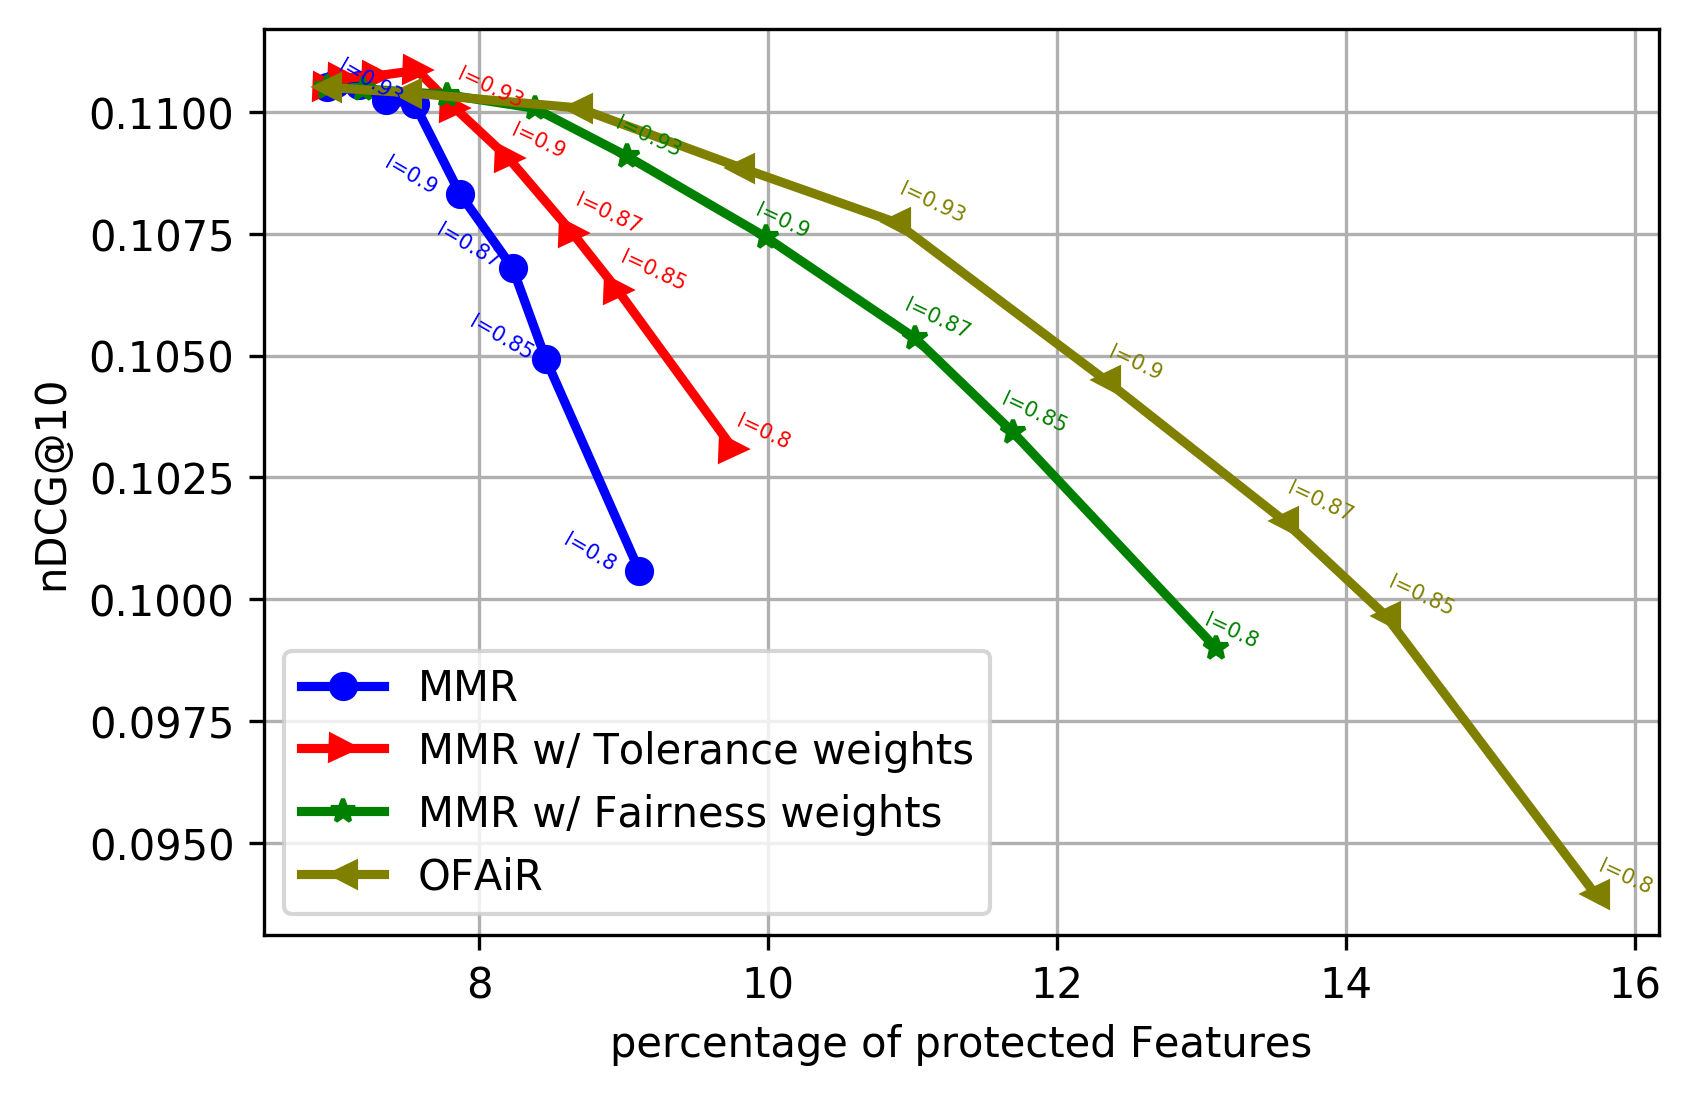

In [111]:
#---content-based MMR---
# mmr_ndcg = [0.054444250124507786, 0.06924104894885269, 0.08526717935822817, 0.08913726297906006, 0.09298531644574065, 0.09693096002219631, 0.1005854422152475, 0.10492389807551489, 0.1067999793433344, 0.10831541647349893, 0.11016451019545336, 0.11024008132706493, 0.11055082901970463, 0.11059180400543796, 0.11050448469611818]
# mmr_cov = [12.173085337488773, 11.58920626360292, 10.7553919030956, 10.517522046509448, 10.150362694706185, 9.689350567589369, 9.107527945395193, 8.461069517438132, 8.230752014324082, 7.867674539163562, 7.553365510834663, 7.3531319946799885, 7.169640785118416, 7.010928403635992, 6.946921478475711]
# mmr_ild = [1.2784241783331116, 1.2490653760392585, 1.1841577678059032, 1.1581659435291576, 1.1234551929040801, 1.0787935724140576, 1.0192466747714983, 0.938736056062011, 0.9003333439200236, 0.8393746788183981, 0.7823604231314508, 0.7502693522706404, 0.7193181423642326, 0.6928593018430887, 0.6806095989664653]

# #--- MMR + tolerance weights---
# mmr_ent_ndcg = [0.060742372271454154, 0.07597874341625363, 0.08911937253809003, 0.09185414454596834, 0.09562822322918191, 0.099413478892813, 0.10309078425709794, 0.10634269244744128, 0.10751269151865321, 0.10904954054093972, 0.11008638527146378, 0.110853103582662, 0.11073859834528689, 0.11068893996036805, 0.11050448469611818]
# mmr_ent_cov = [13.90113622205163, 13.048242533224691, 11.75276228159053, 11.331032575365857, 10.863536540403636, 10.350265437721449, 9.756283687715381, 8.958126948075483, 8.646158562657824, 8.203155028503687, 7.829044289233492, 7.570554343934116, 7.284533214779526, 7.050611390832406, 6.946921478475711]
# mmr_ent_ild = [1.206618999442943, 1.1719243089683655, 1.1070343858036875, 1.0810890392385295, 1.0486874131138488, 1.004927935436556, 0.9512641616077605, 0.8846192832835017, 0.8559017127407993, 0.8133422959389794, 0.7722348557855656, 0.7448910555157685, 0.7184766489696188, 0.6930017245581002, 0.6806095989664653]

# #--- MMR + Fairness weights---
# mmr_f_ndcg = [0.05302813702276024, 0.06560190911103683, 0.08047471530260271, 0.08470735213562999, 0.08816499841373872, 0.09374335788618968, 0.09899995728263528, 0.10342065059856809, 0.10535447078254809, 0.10742470184410266, 0.10909011167811317, 0.11007407001015901, 0.11035453482008722, 0.11047439274387755, 0.11050448469611818]
# mmr_f_cov = [19.134528067606887, 18.18882523955804, 16.51894278157289, 15.90451164109125, 15.154460256855259, 14.249256795982218, 13.09727819602189, 11.695023910870786, 11.018312496998607, 9.987287078683329, 9.024228504884519, 8.385017534744772, 7.776225826549768, 7.195702351042751, 6.946921478475711]
# mmr_f_ild = [1.194529882315252, 1.1721788915871802, 1.122152415441765, 1.1008659811724892, 1.0736464927590712, 1.03719547225844, 0.9896165188735564, 0.9234549960991046, 0.8903004920158449, 0.8349747799563912, 0.7757391314514511, 0.74138887996101, 0.7132898267032387, 0.6905803514451321, 0.6806095989664653]

# #---ofar: MMR + Fair + Entropy---
# ofar_ndcg = [0.05579256672193798, 0.06404519551053064, 0.07745329383557044, 0.08152613709719904, 0.08577065692607995, 0.08966298250273216, 0.0939490334817064, 0.0996631797606491, 0.10160580950894267, 0.10449533800281967, 0.10773088857109046, 0.10885734708042814, 0.11008154037223612, 0.11039530824873503, 0.11050448469611818]
# ofar_cov = [21.0136172752349, 20.221558131643185, 18.825388872105105, 18.314900477368447, 17.682044508426028, 16.829011599265527, 15.72225274518511, 14.272182596291014, 13.57028824324376, 12.334071010824868, 10.884484916218705, 9.807720616026067, 8.686496128463345, 7.501404986275931, 6.946921478475711]
# ofar_ild = [1.1347561867903841, 1.112122548764366, 1.07241140898978, 1.055766160462739, 1.0343159487072042, 1.0064351657433162, 0.9701403678668378, 0.9182469563802603, 0.8913150387288827, 0.8421493157369596, 0.7850994232323774, 0.7489811073973308, 0.7177613370002902, 0.6915015508798765, 0.6806095989664653]


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
capLabels = ['l=0.2', 'l=0.4', 'l=0.6', 'l=0.65', 'l=0.7', 'l=0.75', 'l=0.8', 'l=0.85', 'l=0.87', 'l=0.9', 'l=0.93', 'l=0.95',' l=0.97', 'l=0.99', 'l=1.0']
#----------

cutoff = 6
fig,ax = plt.subplots(1)
ax.plot(mmr_cov[cutoff:], mmr_ndcg[cutoff:], 'o-', linewidth=2.2, label='MMR', color='blue')
ax.plot(mmr_ent_cov[cutoff:], mmr_ent_ndcg[cutoff:], '>-', linewidth=2.2, label='MMR w/ Tolerance weights', color='red')
ax.plot(mmr_f_cov[cutoff:], mmr_f_ndcg[cutoff:], '*-', linewidth=2.2, label='MMR w/ Fairness weights', color='green')
ax.plot(ofar_cov[cutoff:], ofar_ndcg[cutoff:], '<-', linewidth=2.2, label='OFAiR', color='olive')


fig.set_dpi(300)
ax.grid(True)
ax.set_xlabel('percentage of protected Features')
ax.set_ylabel('nDCG@10')
ax.legend()
for i in range(cutoff, len(capLabels)-4):
    ax.annotate(capLabels[i], (mmr_cov[i]-0.55, mmr_ndcg[i]),size=5, rotation=-30, color='blue')
    ax.annotate(capLabels[i], (mmr_ent_cov[i]-0.001, mmr_ent_ndcg[i]),size=5, rotation=-25, color='red')
    ax.annotate(capLabels[i], (mmr_f_cov[i]-0.1, mmr_f_ndcg[i]),size=5, rotation=-25, color='green')
    ax.annotate(capLabels[i], (ofar_cov[i], ofar_ndcg[i]),size=5, rotation=-25, color='olive')
plt.show()

fig.savefig('./UMAP2020_CameraReady/ml_ndcg_featureCov_CountryGenre_cut.png', format='png', dpi=300, bbox_inches='tight')

# item instead of features

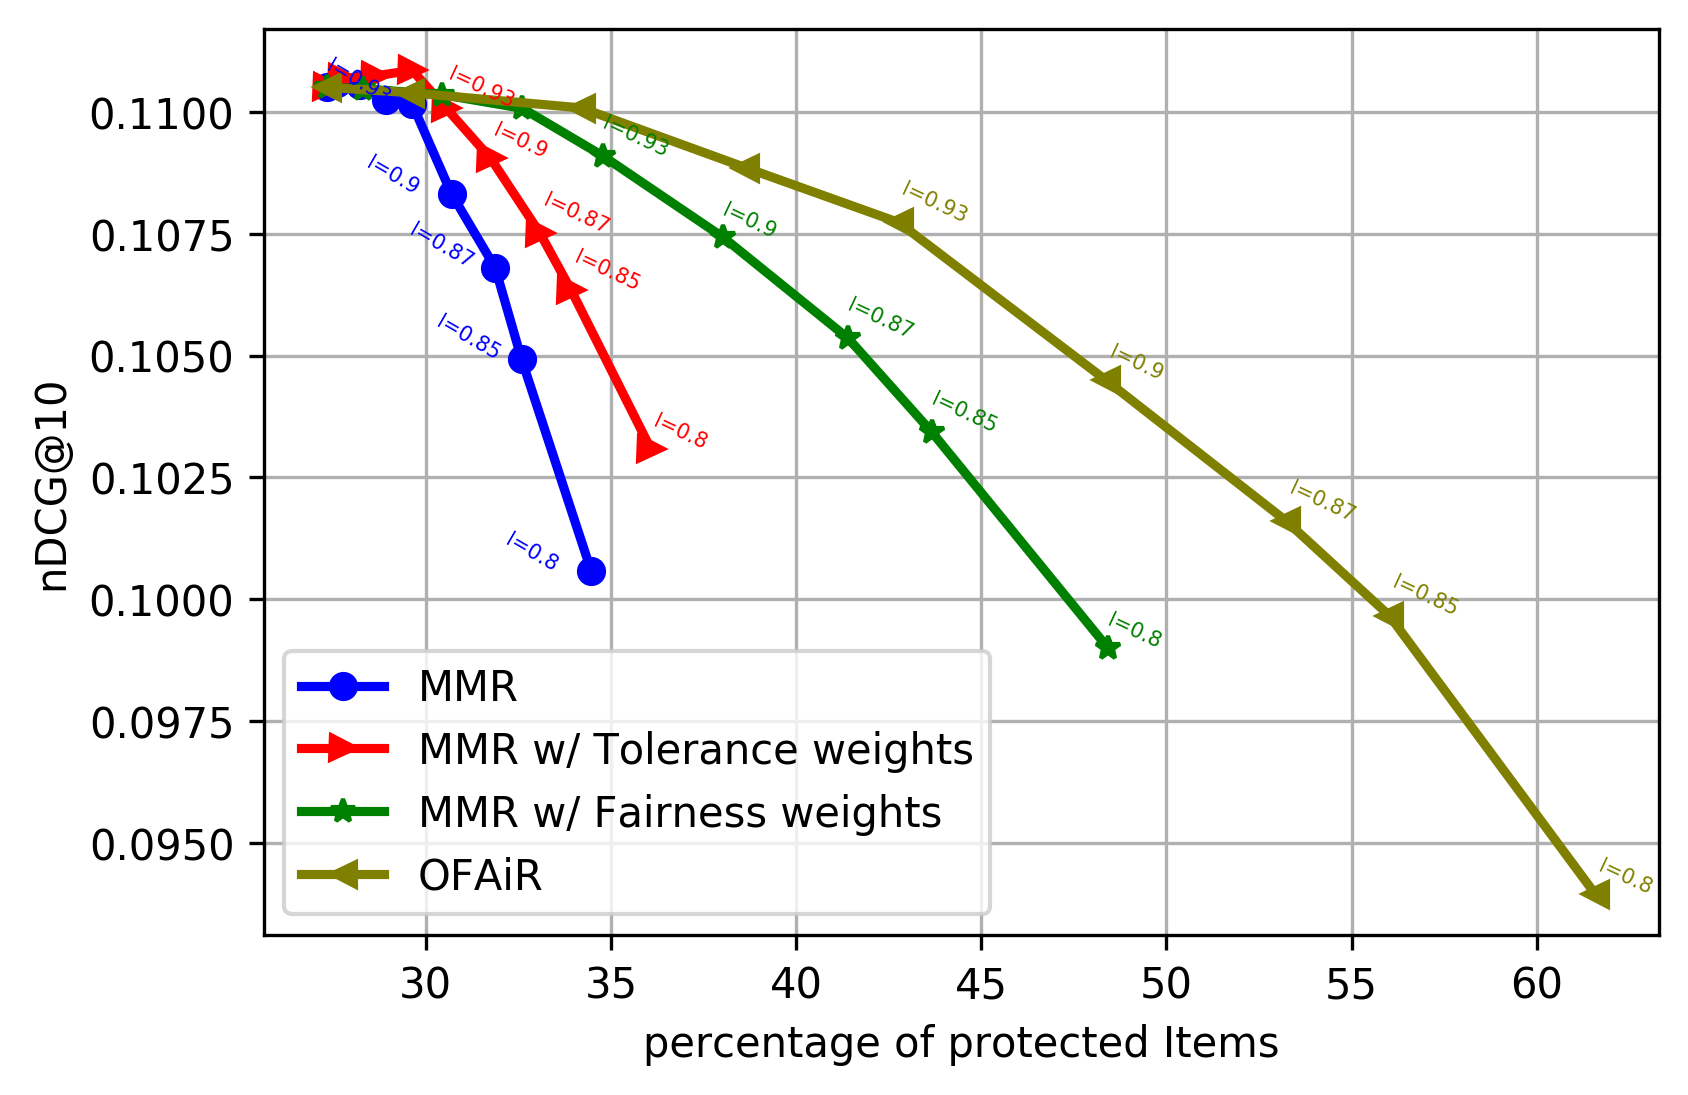

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
capLabels = ['l=0.2', 'l=0.4', 'l=0.6', 'l=0.65', 'l=0.7', 'l=0.75', 'l=0.8', 'l=0.85', 'l=0.87', 'l=0.9', 'l=0.93', 'l=0.95',' l=0.97', 'l=0.99', 'l=1.0']
#----------

cutoff = 6
fig,ax = plt.subplots(1)
ax.plot(mmr_cov_i[cutoff:], mmr_ndcg[cutoff:], 'o-', linewidth=2.2, label='MMR', color='blue')
ax.plot(mmr_ent_cov_i[cutoff:], mmr_ent_ndcg[cutoff:], '>-', linewidth=2.2, label='MMR w/ Tolerance weights', color='red')
ax.plot(mmr_f_cov_i[cutoff:], mmr_f_ndcg[cutoff:], '*-', linewidth=2.2, label='MMR w/ Fairness weights', color='green')
ax.plot(ofar_cov_i[cutoff:], ofar_ndcg[cutoff:], '<-', linewidth=2.2, label='OFAiR', color='olive')


fig.set_dpi(300)
ax.grid(True)
ax.set_xlabel('percentage of protected Items')
ax.set_ylabel('nDCG@10')
ax.legend()
for i in range(cutoff, len(capLabels)-4):
    ax.annotate(capLabels[i], (mmr_cov_i[i]-2.4, mmr_ndcg[i]),size=5, rotation=-30, color='blue')
    ax.annotate(capLabels[i], (mmr_ent_cov_i[i]-0.001, mmr_ent_ndcg[i]),size=5, rotation=-25, color='red')
    ax.annotate(capLabels[i], (mmr_f_cov_i[i]-0.1, mmr_f_ndcg[i]),size=5, rotation=-25, color='green')
    ax.annotate(capLabels[i], (ofar_cov_i[i], ofar_ndcg[i]),size=5, rotation=-25, color='olive')
plt.show()

fig.savefig('./UMAP2020_CameraReady/ml_ndcg_itemCov_CountryGenre_cut.png', format='png', dpi=300, bbox_inches='tight')

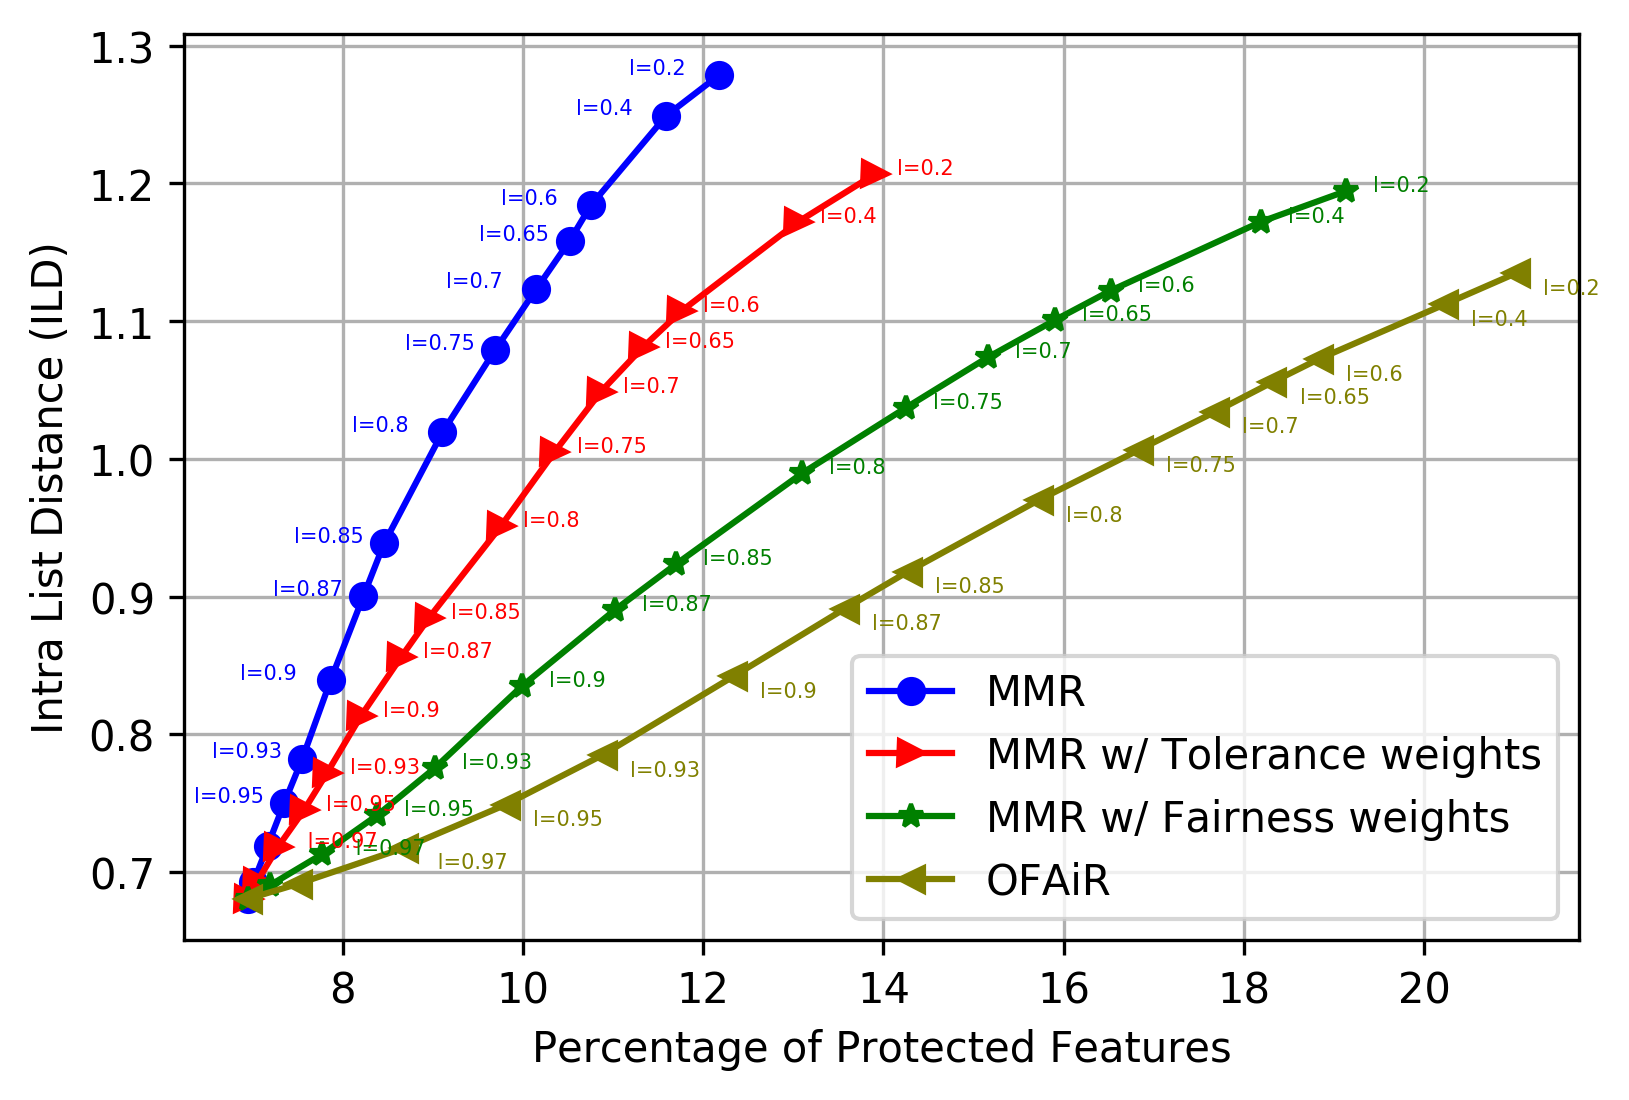

In [49]:
cutoff=0
fig,ax = plt.subplots(1)
ax.plot(mmr_cov[cutoff:], mmr_ild[cutoff:], 'o-', linewidth=1.5, label='MMR', color='blue')
ax.plot(mmr_ent_cov[cutoff:], mmr_ent_ild[cutoff:], '>-', linewidth=1.5, label='MMR w/ Tolerance weights', color='red')
ax.plot(mmr_f_cov[cutoff:], mmr_f_ild[cutoff:], '*-', linewidth=1.5, label='MMR w/ Fairness weights', color='green')
ax.plot(ofar_cov[cutoff:], ofar_ild[cutoff:], '<-', color='olive', linewidth=1.5, label='OFAiR')


# fig.set_figwidth(8)
# fig.set_figheight(5)
fig.set_dpi(300)
ax.grid(True)
# ax.set_ylim([4.0, 12.0])
# ax.set_xlim([5, 30])
# ax.set_ylim([-0.5, 12.0])
# ax.set_xlim([0.0, 30])
ax.set_xlabel('Percentage of Protected Features')
ax.set_ylabel('Intra List Distance (ILD)')
ax.legend()
# for i in range(cutoff, len(capLabels[:13])):
#     ax.annotate(capLabels[i], (mmr_cov[i]-0.4, mmr_ild[i]+0.001),size=5, rotation=30, color='blue')
#     ax.annotate(capLabels[i], (mmr_ent_cov[i]+0.1, mmr_ent_ild[i]),size=5,rotation=30, color='red')
#     ax.annotate(capLabels[i], (mmr_f_cov[i]+0.15, mmr_f_ild[i]),size=5, rotation=30, color='green')
#     ax.annotate(capLabels[i], (ofar_cov[i], ofar_ild[i]-0.015),size=5, rotation=30, color='olive')
# plt.show()

for i in range(cutoff, len(capLabels[:13])):
    ax.annotate(capLabels[i], (mmr_cov[i]-1, mmr_ild[i]+0.001),size=5, rotation=0, color='blue')
    ax.annotate(capLabels[i], (mmr_ent_cov[i]+0.25, mmr_ent_ild[i]),size=5,rotation=0, color='red')
    ax.annotate(capLabels[i], (mmr_f_cov[i]+0.3, mmr_f_ild[i]),size=5, rotation=0, color='green')
    ax.annotate(capLabels[i], (ofar_cov[i]+0.3, ofar_ild[i]-0.015),size=5, rotation=0, color='olive')
plt.show()
# fig.savefig('./UMAP2020_CameraReady/ml_ild_perc_protected_relationship_CountryGenre.png', format='png', dpi=300, bbox_inches='tight')
# fig.savefig('./UMAP2020_CameraReady/ml_ild_featureCov_CountryGenre_cut.png', format='png', dpi=300, bbox_inches='tight')


# unique items rather than unique features

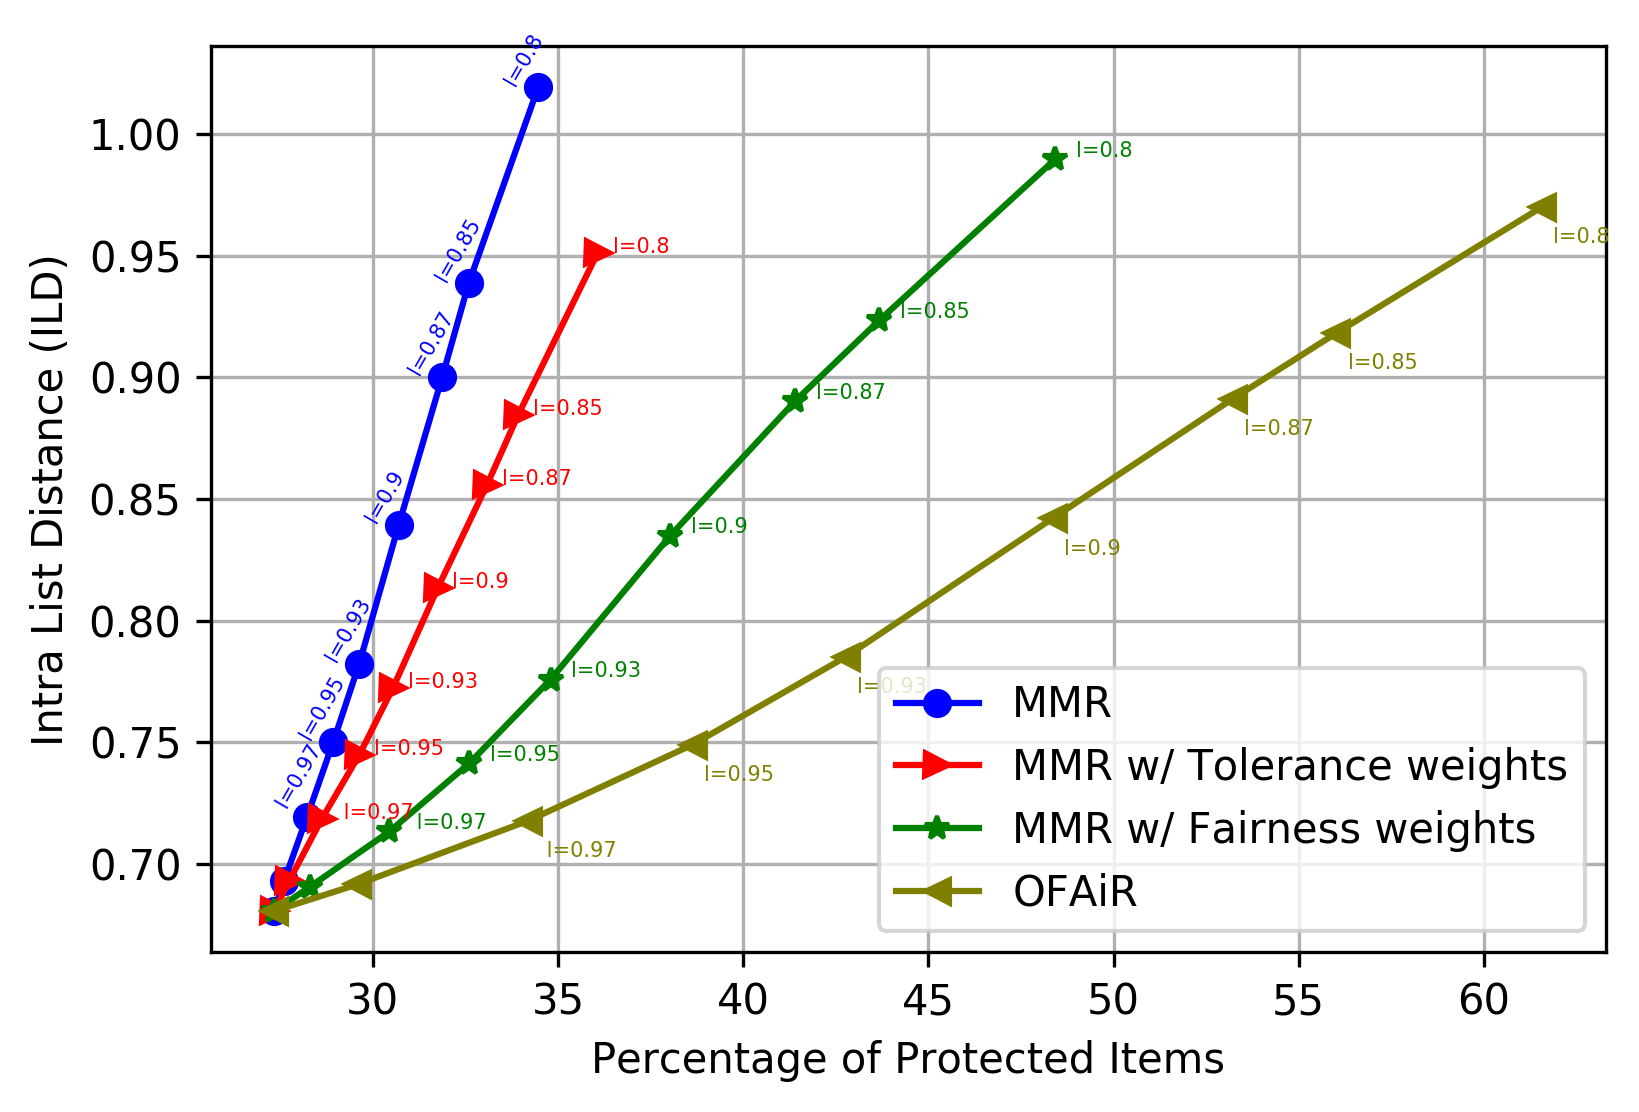

In [79]:
cutoff=6
fig,ax = plt.subplots(1)
ax.plot(mmr_cov_i[cutoff:], mmr_ild[cutoff:], 'o-', linewidth=1.5, label='MMR', color='blue')
ax.plot(mmr_ent_cov_i[cutoff:], mmr_ent_ild[cutoff:], '>-', linewidth=1.5, label='MMR w/ Tolerance weights', color='red')
ax.plot(mmr_f_cov_i[cutoff:], mmr_f_ild[cutoff:], '*-', linewidth=1.5, label='MMR w/ Fairness weights', color='green')
ax.plot(ofar_cov_i[cutoff:], ofar_ild[cutoff:], '<-', color='olive', linewidth=1.5, label='OFAiR')


# fig.set_figwidth(8)
# fig.set_figheight(5)
fig.set_dpi(300)
ax.grid(True)
# ax.set_ylim([4.0, 12.0])
# ax.set_xlim([5, 30])
# ax.set_ylim([-0.5, 12.0])
# ax.set_xlim([0.0, 30])
ax.set_xlabel('Percentage of Protected Items')
ax.set_ylabel('Intra List Distance (ILD)')
ax.legend()
# for i in range(cutoff, len(capLabels[:13])):
#     ax.annotate(capLabels[i], (mmr_cov_i[i]-1, mmr_ild[i]),size=5, rotation=30, color='blue')
#     ax.annotate(capLabels[i], (mmr_ent_cov_i[i]+0.1, mmr_ent_ild[i]),size=5,rotation=30, color='red')
#     ax.annotate(capLabels[i], (mmr_f_cov_i[i]+0.15, mmr_f_ild[i]),size=5, rotation=30, color='green')
#     ax.annotate(capLabels[i], (ofar_cov_i[i], ofar_ild[i]-0.015),size=5, rotation=30, color='olive')
# plt.show()



# for i in range(cutoff, len(capLabels[:13])):
#     ax.annotate(capLabels[i], (mmr_cov_i[i]-2, mmr_ild[i]+0.001),size=5, rotation=0, color='blue')
#     ax.annotate(capLabels[i], (mmr_ent_cov_i[i]+0.25, mmr_ent_ild[i]),size=5,rotation=0, color='red')
#     ax.annotate(capLabels[i], (mmr_f_cov_i[i]+0.3, mmr_f_ild[i]),size=5, rotation=0, color='green')
#     ax.annotate(capLabels[i], (ofar_cov_i[i]+0.3, ofar_ild[i]-0.015),size=5, rotation=0, color='olive')
# plt.show()

for i in range(cutoff, len(capLabels[:13])):
    ax.annotate(capLabels[i], (mmr_cov_i[i]-1, mmr_ild[i]+0.001),size=5, rotation=60, color='blue')
#     ax.annotate(capLabels[i], (mmr_cov_i[i]-2.5, mmr_ild[i]+0.001),size=5, rotation=0, color='blue')
    ax.annotate(capLabels[i], (mmr_ent_cov_i[i]+0.4, mmr_ent_ild[i]),size=5,rotation=0, color='red')
    ax.annotate(capLabels[i], (mmr_f_cov_i[i]+0.56, mmr_f_ild[i]+0.001),size=5, rotation=0, color='green')
    ax.annotate(capLabels[i], (ofar_cov_i[i]+0.3, ofar_ild[i]-0.015),size=5, rotation=0, color='olive')
plt.show()
# fig.savefig('./UMAP2020_CameraReady/ml_ild_perc_protected_ITEMS_relationship_CountryGenre.png', format='png', dpi=300, bbox_inches='tight')
fig.savefig('./UMAP2020_CameraReady/ml_ild_itemCov_CountryGenre_cut.png', format='png', dpi=300, bbox_inches='tight')

In [84]:
lam=0.2

# -------------------------------------------------------------------------------------------------------------------------------

filename = './UMAP2020_CameraReady/ml_results/rec_MMR_lam%s.csv'%lam
mmr_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

filename = './UMAP2020_CameraReady/ml_results/rec_tol_MMR_lam%s.csv'%lam
ent_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

filename = './UMAP2020_CameraReady/ml_results/rec_tol_fair_MMR_lam%s_twoFeatures100.csv'%lam
fair_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

filename = './UMAP2020_CameraReady/ml_results/rec_MMR_fair_lam%s_twoFeatures100.csv'%lam
f_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

# -------------------------------------------------------------------------------------------------------------------------------

nmf_items = list(map(int,nmf_at10_df['itemid'].tolist()))
print('# nmf unique items',len(set(nmf_items)),len(nmf_items))

mmr_items = list(map(int,mmr_rr_recs['itemid'].tolist()))
print('# mmr  unique items',len(set(mmr_items)), len(mmr_items))

ent_items = list(map(int,ent_rr_recs['itemid'].tolist()))
print('# ent  unique items',len(set(ent_items)), len(ent_items))

fair_items = list(map(int,fair_rr_recs['itemid'].tolist()))
print('# fair  unique items',len(set(fair_items)), len(fair_items))

f_items = list(map(int, f_rr_recs['itemid'].tolist()))
print('# f  unique items', len(set(f_items)), len(f_items))

# nmf unique items 728 60000
# mmr  unique items 944 60000
# ent  unique items 1136 60000
# fair  unique items 976 60000
# f  unique items 838 60000


In [85]:
a = item_features_df.loc[nmf_items].sum(axis=0) / item_features_df.loc[nmf_items].sum(axis=0).sum() * 100
b = item_features_df.loc[mmr_items].sum(axis=0) / item_features_df.loc[mmr_items].sum(axis=0).sum() * 100
c = item_features_df.loc[ent_items].sum(axis=0) / item_features_df.loc[ent_items].sum(axis=0).sum() * 100
d = item_features_df.loc[f_items].sum(axis=0) / item_features_df.loc[f_items].sum(axis=0).sum() * 100
e = item_features_df.loc[fair_items].sum(axis=0) / item_features_df.loc[fair_items].sum(axis=0).sum() * 100

# select the protected attributes
df = pd.concat([a[pro],b[pro],c[pro],d[pro],e[pro]], axis=1)
df.columns = ['NMF', 'MMR', 'MMR + ent ws', 'MMR + fair ws', 'MMR + ent & fair ws']
df

,NMF,MMR,MMR + ent ws,MMR + fair ws,MMR + ent & fair ws
CA,0.178857,0.511076,0.447465,0.938137,0.737608
DE,0.328921,1.168128,1.024360,1.361379,1.205922
ES,0.008638,0.550684,0.545984,0.729299,0.689613
HK,0.108568,0.567454,0.360187,0.744356,0.661603
Horror,0.335527,0.425311,0.783519,1.167107,1.542539
Music,0.220523,0.545574,0.598053,1.298368,1.555316
History,0.608894,0.532956,0.837902,0.806877,1.379391
Mystery,1.086524,0.764218,1.119738,1.403605,1.686850


In [86]:
p_country_row = df.iloc[:4, :].sum(axis=0)
p_genre_row = df.iloc[4:, :].sum(axis=0)
tbl = pd.concat([pd.DataFrame(p_country_row), pd.DataFrame(p_genre_row)],axis=1,ignore_index=True).T
tbl.rename(index={0:'pro countries', 1:'pro genres'})

,NMF,MMR,MMR + ent ws,MMR + fair ws,MMR + ent & fair ws
pro countries,0.624984,2.797342,2.377997,3.773171,3.294747
pro genres,2.251467,2.268059,3.339212,4.675956,6.164095


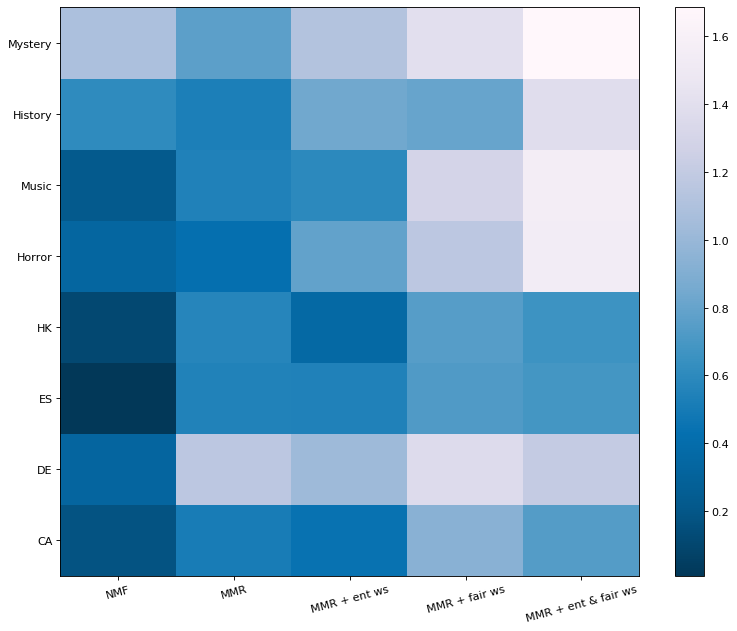

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

cmaplist=['PuBu_r','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaplist2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']


plt.pcolor(df,cmap='PuBu_r')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=15)
plt.colorbar()
# plt.show()
plt.tight_layout()
plt.savefig('./UMAP2020_CameraReady/heatmap_ml_CountryGenre.png',dpi=300)

In [88]:
bl = df.loc[df.index[:4].tolist()].sum().tolist()
rd = df.loc[df.index[4:].tolist()].sum().tolist()

# labels = ["protected genres", "protected countries"]

# fig, ax = plt.subplots()
# ax.stackplot(df.columns.tolist(), rd, bl, labels=labels, colors=['red', 'blue'])
# ax.legend(loc='upper left')
# plt.xlabel("algorithms")
# plt.ylabel("% protected items")
# plt.show()
# plt.savefig('./UMAP2020_CameraReady/stackplot_ml_lambda0.2.png',dpi=100)

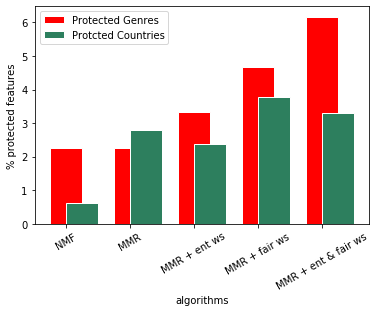

In [222]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import rc
import pandas as pd
 
# y-axis in bold
# rc('font', weight='bold')
 
bars = np.add(bl, rd).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = df.columns.tolist()
barWidth = 0.5

plt.bar(r, rd, color='red', edgecolor='white', width=barWidth, label='Protected Genres')    
plt.bar(np.array(r)+0.25, bl, color='#2d7f5e', edgecolor='white', width=barWidth, label='Protcted Countries')

    
# Custom X axis
plt.xticks(r, names, rotation=30)
plt.xlabel("algorithms")
plt.ylabel("% protected features")
plt.legend()
 
# Show graphic
# plt.show()
plt.savefig('./UMAP2020_CameraReady/barplot_ml_lambda0.2_CountryGenre.png',dpi=100, bbox_inches='tight')